# News Group Classification

The following notebook is based on code from a [fast.ai MOOC Lesson3](https://course.fast.ai/videos/?lesson=3). 
It was presented at the [2019 October Desert Data Science User Group](https://www.meetup.com/Desert-Data-Science-User-Group/events/265691365/)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.callbacks import *
from IPython.display import display, Image

## Data Description

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. You can download the [Dataset](http://qwone.com/~jason/20Newsgroups/) and follow along the tutorial.

The categories are as follows:


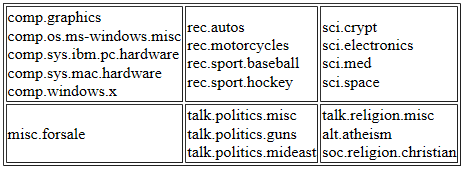

In [68]:
display(Image(filename='C:\\Users\\p1thiyya\\Downloads\\20_news_desc.PNG'))

## Extracting the data

In [6]:
from pathlib import Path
path = Path('C:\\Users\\pradeep.thiyyagura\\Documents\\Learning\\Meetup_19\\20_newsgroups')
working = Path('C:\\Users\\pradeep.thiyyagura\\Documents\\Learning\\Meetup_19\\working')

In [7]:
os.chdir(working)

In [8]:
from os import walk

# Get the list of all files in directory tree at given path
Files = list()
for (dirpath, dirnames, filenames) in os.walk(path):
    Files +=[os.path.join(dirpath, file) for file in filenames]


In [45]:
print(len(Files))
Files[:5]

19997


['C:\\Users\\pradeep.thiyyagura\\Documents\\Learning\\Meetup_19\\20_newsgroups\\alt.atheism\\49960',
 'C:\\Users\\pradeep.thiyyagura\\Documents\\Learning\\Meetup_19\\20_newsgroups\\alt.atheism\\51060',
 'C:\\Users\\pradeep.thiyyagura\\Documents\\Learning\\Meetup_19\\20_newsgroups\\alt.atheism\\51119',
 'C:\\Users\\pradeep.thiyyagura\\Documents\\Learning\\Meetup_19\\20_newsgroups\\alt.atheism\\51120',
 'C:\\Users\\pradeep.thiyyagura\\Documents\\Learning\\Meetup_19\\20_newsgroups\\alt.atheism\\51121']

In [10]:
news_group_df = pd.DataFrame({'File_path': pd.Series(Files)})
news_group_df.head()

,File_path
0,C:\Users\pradeep.thiyyagura\Documents\Learning...
1,C:\Users\pradeep.thiyyagura\Documents\Learning...
2,C:\Users\pradeep.thiyyagura\Documents\Learning...
3,C:\Users\pradeep.thiyyagura\Documents\Learning...
4,C:\Users\pradeep.thiyyagura\Documents\Learning...


In [11]:
def extract_contents(file):
    #file_label = file.split('\\')[-2]
    with open(file, encoding = "ISO-8859-1") as myfile:
        text = myfile.read()
        i = text.find('\n\n') #skip header
        if 0 < i:
            text = text[i+2:]       
        #file_text = myfile.readlines()[1:] #removing the first line as it has the label 
    return str(text)


In [46]:
extract_contents(Files[1020])

"In article <1993Apr6.011605.909@cis.uab.edu> sloan@cis.uab.edu\n(Kenneth Sloan) writes:\n>\n>Why didn't you create 8 grey-level images, and display them for\n>1,2,4,8,16,32,64,128... time slices?\n\nBy '8 grey level images' you mean 8 items of 1bit images?\nIt does work(!), but it doesn't work if you have more than 1bit\nin your screen and if the screen intensity is non-linear.\n\nWith 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,\nthis gives 16 levels, but they are linear if screen intensity is\nlinear.\nWith 1*c_1 + 2*c_2 it works, but we have to find the best\ncompinations -- there's 10 levels, but 16 choises; best 10 must be\nchosen. Different compinations for the same level, varies a bit, but\nthe levels keeps their order.\n\nReaders should verify what I wrote... :-)\n\nJuhana Kouhia\n"

In [13]:
news_group_df['File_label'] = news_group_df['File_path'].apply(lambda x: x.split('\\')[-2])
news_group_df['File_text'] = news_group_df['File_path'].apply(lambda x: extract_contents(x))

In [14]:
news_group_df.sample(10)

,File_path,File_label,File_text
14837,C:\Users\pradeep.thiyyagura\Documents\Learning...,sci.space,"In article <C69qA6.J4w.1@cs.cmu.edu>, 00042444..."
10430,C:\Users\pradeep.thiyyagura\Documents\Learning...,rec.sport.hockey,In article <gp2011-200493132808@m248-68.bgsu.e...
2120,C:\Users\pradeep.thiyyagura\Documents\Learning...,comp.os.ms-windows.misc,\nHi.\nI'd like to substitute the exciting win...
12878,C:\Users\pradeep.thiyyagura\Documents\Learning...,sci.electronics,From article <1993Apr25.201129.1239@Princeton....
18700,C:\Users\pradeep.thiyyagura\Documents\Learning...,talk.politics.misc,In article <1993Apr21.230622.6138@gn.ecn.purdu...
19412,C:\Users\pradeep.thiyyagura\Documents\Learning...,talk.religion.misc,In article <17609.459.uupcb@ozonehole.com> ant...
12712,C:\Users\pradeep.thiyyagura\Documents\Learning...,sci.electronics,idh@nessie.mcc.ac.uk (Ian Hawkins) writes:\n\n...
4427,C:\Users\pradeep.thiyyagura\Documents\Learning...,comp.sys.mac.hardware,In article <1qcq4gINN2q7@calvin.usc.edu> wls@c...
13236,C:\Users\pradeep.thiyyagura\Documents\Learning...,sci.med,In article <1993Apr16.194316.25522@ohsu.edu> t...
2036,C:\Users\pradeep.thiyyagura\Documents\Learning...,comp.os.ms-windows.misc,\nIn article <1rfdkqINN8s2@zephyr.grace.cri.nz...


## Create a test label

In [16]:
news_group_df.to_pickle('news_group_df_local.pkl')

In [17]:
news_group_df = pd.read_pickle("news_group_df_local.pkl")

In [18]:
news_dfv = pd.DataFrame([])
np.random.seed(40)
for label in np.unique(news_group_df['File_label']):
    label_df = news_group_df[news_group_df["File_label"]==label]
    label_df.reset_index(drop = True)
    rand_index = np.random.choice([False,True], size=label_df.shape[0], p=[0.8,0.2])
    label_df.loc[:,'is_test'] = list(rand_index)
    label_df = label_df.copy()
    news_dfv = news_dfv.append(label_df, ignore_index=True)

C:\Users\pradeep.thiyyagura\AppData\Local\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\pradeep.thiyyagura\AppData\Local\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


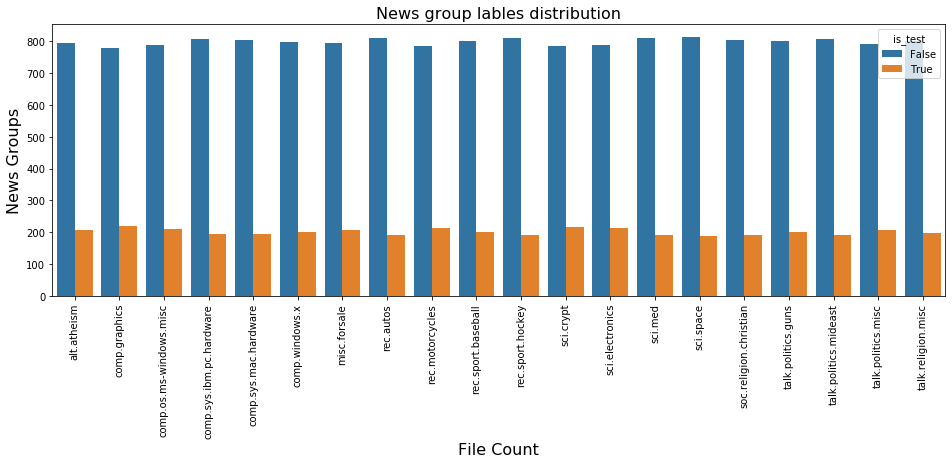

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
sns.countplot(data=news_dfv, x = 'File_label', hue = 'is_test')
plt.title('News group lables distribution', fontsize=16)
plt.xlabel('File Count', fontsize=16)
plt.ylabel('News Groups', fontsize=16)
plt.xticks(rotation='vertical');

## Preparing the data for Fastiai.text 

In [21]:
df_train = news_dfv[news_dfv["is_test"]==False]
df_test = news_dfv[news_dfv["is_test"]==True]

df_tst = df_test[["File_label","File_text"]]
df_trn = df_train[["File_label","File_text"]]

df_tst.columns = ['label','text']
df_trn.columns = ['label','text']

print("Number of rows in  Training data")
print(df_trn.shape[0])

print("Number of rows in Testing data")
print(df_tst.shape[0])

Number of rows in  Training data
15958
Number of rows in Testing data
4039


## Language Model

In [22]:
data_lm = TextLMDataBunch.from_df('.', df_trn,df_tst,text_cols='text',label_cols='label')

In [23]:
data_lm.show_batch()

idx,text
0,"paraphernalia are \n available from the xxmaj freedom xxmaj from xxmaj religion xxmaj foundation in the xxup us . \n \n xxmaj write to : xxup xxunk , xxup p.o. xxmaj box 750 , xxmaj madison , xxup wi xxunk . \n xxmaj telephone : ( 608 ) 256 - 8900 \n \n xxup evolution xxup designs \n \n xxmaj evolution xxmaj designs sell the"
1,"experiments . xxmaj what started as a genetic fluke in the mid 1400 's is now \n scientifically engineered and bred for . xxmaj the whole bone transplant idea \n started in the mid sixties inspired by doctor xxmaj timothy xxmaj leary \n xxunk deer bone cells into small white rats . "" xxmaj gillow is quick \n to point out the assassination attempt on xxmaj"
2,"subject like this you just have a spiral . xxmaj what \n would then be a morality of a morality of morals . xxmaj labels do n't make arguments . \n xxmaj one really needs a solid measuring stick by which most actions can be \n interpreted , even though this would hardly seem moral . xxmaj for example "" xxmaj the best \n thing for"
3,"$ > > > slack@ncsu.edu < < < $ "" xxmaj my used underwear \n xxmaj consumption ! $ $ is legal tender in \n xxup po xxmaj box 30904 $ xxup bbs : ( 919 ) 782 - 3095 $ 28 countries ! "" \n xxmaj raleigh , xxup nc 27622 $ xxmaj warning : i hoard pennies . $ --""bob "" \n \n xxbos"
4,"+ xxmaj unix : sunos , a / xxup ix , xxup hp - xxup ux , xxmaj unicos , xxup dg / xxup ux , xxmaj ultrix \n + xxmaj other platforms : xxup vms , xxmaj amiga / xxmaj exec , xxup ms - xxup dos , xxup os / 2 , next \n + \n + xxmaj authors : xxmaj many . xxmaj the"


In [24]:
data_lm.save()

In [25]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3,pretrained=True)

In [26]:
TEXTS = ["Staring into the sky",
         "Politics are so divided these days",
         "I really like this software"]

N_WORDS = 40
N_SENTENCES = 2

### Before training the language model

In [27]:
for TEXT in TEXTS:
    print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
    print("\n")

Staring into the sky with a white eye line due to the light and the light , the red eye line is the main feature of the eye . The eye is able to lock as well as see the light , and
Staring into the sky by a mirror is an image of the moon . The bird 's appearance is reflected in the nshah@acs.bu.edu image , where the colour of the sky is shown . The body of the Venus - like


Politics are so divided these days are common only within the National Assembly . Each of the " Parties " is the party that is elected . It is the national party ( DEMOCRAT ) of the U.S.
Politics are so divided these days include : 
  Politics of politics , religion , politics , religion , religion , religion , religion , religion and religion . 
  Politics 
  The political climate typically associated with foreign authority is not contradictory


I really like this software you 'll expect . You can get a lot of money and it 's just because you have a good job . You can ' t put the Fisher Company in the game , i th

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 1.45E-02


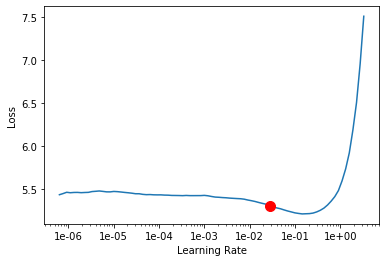

In [43]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
#learn.recorder.plot(suggestion=True,skip_end=15)

In [44]:
learn.fit_one_cycle(5, 2.75E-02,callbacks=[SaveModelCallback(learn, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.148411,3.171141,0.342857,05:12
1,4.117485,3.046154,0.385714,05:11
2,3.884022,2.907020,0.371429,05:11
3,3.546596,2.854224,0.400000,05:11
4,3.316654,2.847031,0.400000,05:11


Better model found at epoch 0 with valid_loss value: 3.1711409091949463.
Better model found at epoch 1 with valid_loss value: 3.0461535453796387.
Better model found at epoch 2 with valid_loss value: 2.907020330429077.
Better model found at epoch 3 with valid_loss value: 2.8542237281799316.
Better model found at epoch 4 with valid_loss value: 2.847031354904175.


In [28]:
learn.load('best_lm');

### After training the language model with 20 news groups data

In [32]:
for TEXT in TEXTS:
    print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
    print("\n")

Staring into the sky of the 0 Astrophysics reading in particular . All of 'm green atheists 
  results in though atheists : 
  Health care would be nice believe they were not since arabs for the 	  to date 
 
Staring into the sky % of the 340 i have been underrated . 
  +46 ( Basis - is a person who 
  had a Assumptions assumptions that he was AV / fixture martyr deletia- tvtwm . 
 


Politics are so divided these days ) ' ) maybe you would have to be 
  Clipper Chip ( problem send it to the MISSION - . 
 
  In article \ polycarp > sanction will : 
 
  > To 9
Politics are so divided these days ' Clipper Chip ( i civil - that they are n't here , but i am not interested in the internet . 
 
  The Clipper Chip is a repeat in the Clipper chip .


I really like this software to be a nl.cs.cmu.edu non of the practices . While . 
 
  -- 
  Beyond Aluminum , 1996 and Instructed 
 
  File : Post Koresh . Scaling . Got 1.1
I really like this software does not go . You work n't 
  civil it is a g

In [13]:
learn.save_encoder('news_fine_tuned_enc')

## Prepare data for classification model

In [33]:
data_clas  = TextClasDataBunch.from_df('.',
                                       df_trn,
                                       df_tst,
                                       vocab=data_lm.train_ds.vocab,
                                       bs=48)

In [34]:
data_clas.c,data_clas.classes

(20,
 ['alt.atheism',
  'comp.graphics',
  'comp.os.ms-windows.misc',
  'comp.sys.ibm.pc.hardware',
  'comp.sys.mac.hardware',
  'comp.windows.x',
  'misc.forsale',
  'rec.autos',
  'rec.motorcycles',
  'rec.sport.baseball',
  'rec.sport.hockey',
  'sci.crypt',
  'sci.electronics',
  'sci.med',
  'sci.space',
  'soc.religion.christian',
  'talk.politics.guns',
  'talk.politics.mideast',
  'talk.politics.misc',
  'talk.religion.misc'])

In [55]:
data_clas.show_batch()

text,target
xxbos xxunk ( xxmaj owen xxmaj adair ) writes : \n \n > xxmaj in article < 1993apr20.173506.2288@dlss2 > james@dlss2 ( xxmaj james xxmaj cummings ) writes : \n > > xxmaj newsgroups : comp.os.ms-windows.misc \n > > xxmaj path : atldbs!uupsi!psinntp!uunet!gatech!howland.reston.ans.net!bogus.sura.net!darwin.sura.net!convex!seas.smu.edu!void!dalnet!dlss2!james \n > > xxmaj from : james@dlss2 ( xxmaj james xxmaj cummings ) \n > > xxmaj subject : xxmaj re : xxmaj,comp.os.ms-windows.misc
"xxbos xxrep 10 - cut here xxrep 10 - part 03 / 03 \n xxup xxunk a \ - \ ( $ xxup xxunk xxup xxunk < # xxup xxunk ( \n xxup xxunk u ) xxup d@ / xxup xxunk < xxup xxunk < xxup xxunk # xxup xxunk xxup ad . "" / , ( , xxup v1 # & w ; \n xxup xxunk",comp.os.ms-windows.misc
"xxbos xxmaj archive - name : net - privacy / part2 \n xxmaj last - modified : 1993 / 3 / 3 \n xxmaj version : 2.1 \n \n \n xxup identity , xxup privacy , and xxup anonymity on the xxup internet \n xxrep 48 = \n \n ( c ) 1993 xxup l. xxmaj detweiler . xxmaj not for commercial use except by",sci.crypt
xxbos xxmaj archive - name : jpeg - faq \n xxmaj last - modified : 2 xxmaj may 1993 \n \n xxmaj this xxup faq article discusses xxup jpeg image compression . xxmaj suggestions for \n additions and clarifications are welcome . \n \n xxmaj new since version of 18 xxmaj april 1993 : \n * xxmaj new version of xxup xv supports 24-bit viewing,comp.graphics
xxbos xxmaj we have received a number of requests for a reposting of the \n xxmaj international xxmaj obfuscated c xxmaj code xxmaj contest rules and guidelines . xxmaj also \n some people requested that these rules be posted to a wider set of \n groups . xxmaj sorry for the cross posting . \n \n xxmaj some technical clarifications were made to the rules and,comp.windows.x


In [65]:
for i, tok in enumerate(data_clas.vocab.itos[:20]):
    print(f'{i} {tok}')

0 xxunk
1 xxpad
2 xxbos
3 xxeos
4 xxfld
5 xxmaj
6 xxup
7 xxrep
8 xxwrep
9 
 
10 ,
11 the
12 .
13 >
14 to
15 of
16 a
17 
 
 
18 and
19 i


In [67]:
data_clas.train_ds[0][0].text[:100]

'xxbos xxmaj archive - name : atheism / resources \n  xxmaj alt - atheism - archive - name : resources'

In [61]:
data_clas.train_ds[0][0].data[:10]

array([   2,    5, 1424,   22,  302,   27, 1592,   29, 1376,    9], dtype=int64)

In [68]:
data_clas.save()

In [36]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)

In [11]:
learn_clas.load_encoder('news_fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 2.51E-02


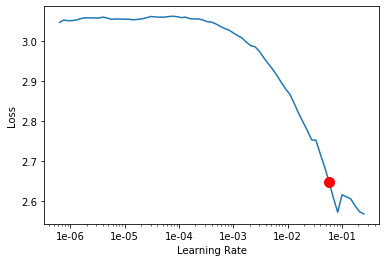

In [71]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True,skip_end=15)

In [73]:
learn_clas.fit_one_cycle(1,5.75E-02,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.158847,0.843525,0.726913,02:58


In [74]:
learn_clas.save('clas_first')

In [76]:
learn_clas.load('clas_first');

In [77]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.852581,0.719486,0.777173,03:02


In [78]:
learn_clas.save('clas_second')

In [13]:
learn_clas.load('clas_second');

In [19]:
import torch
torch.cuda.empty_cache()

In [18]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.657458,0.579585,0.810349,04:23


In [14]:
learn_clas.load('clas_second');

In [15]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7) )

epoch,train_loss,valid_loss,accuracy,time
0,0.704038,0.651090,0.791037,04:20
1,0.603815,0.622480,0.802922,04:20
2,0.571168,0.595029,0.818272,03:57
3,0.457325,0.573945,0.825947,04:22
4,0.334473,0.548988,0.846002,04:05
5,0.258782,0.559543,0.851448,04:10
6,0.174118,0.568482,0.849963,04:01
7,0.153250,0.567101,0.852934,04:40
8,0.106280,0.584373,0.853677,04:10
9,0.099035,0.588052,0.851944,04:23


In [16]:
learn_clas.save('clas_third')

In [12]:
learn_clas.load('clas_second');

In [13]:
learn_clas.freeze_to(-6)
learn_clas.fit_one_cycle(4, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7) )

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 101.13 MiB (GPU 0; 12.00 GiB total capacity; 9.35 GiB already allocated; 98.45 MiB free; 136.49 MiB cached)

### We are out of memory!!!

Lets check the state of the art for this task [LINK] (https://paperswithcode.com/sota/text-classification-on-20news)

If we had enough GPU memory and more epochs we could have improved the accuracy a bit more.

## Make predictions on the test data

In [37]:
learn_clas.load('clas_third');

In [42]:
#Get test data predictions with  %probabilities and loss
def argNmax(a, N, axis=None):
    if axis is None:
        return np.argpartition(a.ravel(), -N)[-N]
    else:
        return np.take(np.argpartition(a, -N, axis=axis), -N, axis=axis)


def make_predictions_testdata():
    y_pred, y_true, loss =  learn_clas.get_preds(ds_type=DatasetType.Valid, ordered = True, with_loss = True)
    Pred_tst = []
    Pred_tst_pro = []
    Actual_tst = []
    Actual_tst_pro = []
    Loss_tst = []
    prd_cat, num_cat, prob, data_text_c = [],[],[],[]
    first_cat, second_cat, third_cat = [],[],[]
    first_cat_p, second_cat_p, third_cat_p = [],[],[]
    for r in range(0,df_tst.shape[0]):
        pro = y_pred[r].numpy()*100
        arg1max,arg2max,arg3max = argNmax(pro,1),argNmax(pro,2),argNmax(pro,3)
        first_cat_l, first_cat_percent = data_clas.classes[arg1max], round(pro[arg1max],2)
        second_cat_l, second_cat_percent = data_clas.classes[arg2max], round(pro[arg2max],2)
        third_cat_l,third_cat_percent = data_clas.classes[arg3max], round(pro[arg3max],2)
        true_cat = np.asarray(y_true[r]).tolist()
        true_cat_l, true_cat_precent = data_clas.classes[true_cat], round(pro[true_cat],2)
        first_cat.append(first_cat_l)
        second_cat.append(second_cat_l)
        third_cat.append(third_cat_l)    
        first_cat_p.append(first_cat_percent)
        second_cat_p.append(second_cat_percent)
        third_cat_p.append(third_cat_percent)

        Pred_tst.append(first_cat_l)
        Pred_tst_pro.append(first_cat_percent)
        Actual_tst.append(true_cat_l)
        Actual_tst_pro.append(true_cat_precent)
        Loss_tst.append(np.asarray(loss[r]))

    test_prediction_df = pd.DataFrame({'c_filename':df_test['File_path'],
                       'Loss':Loss_tst,           
                       'actual_label': df_test['File_label'],
                       'actual_label_prob':Actual_tst_pro,
                       'predicted_label' : first_cat,
                       'predicted_label_prob' : first_cat_p,
                       'second_label': second_cat,
                       'second_label_prob' : second_cat_p,
                       'third_label': third_cat,
                       'third_label_prob' : third_cat_p})

    test_prediction_df.sort_values(by=['Loss'], ascending = False, inplace = True)
    test_prediction_df.Loss = test_prediction_df.Loss.astype('float64') 

    return test_prediction_df

In [44]:
#Make prediction on the test data with loss
predict_df = make_predictions_testdata()

In [47]:
predict_df = pd.read_pickle('model_predictions_testdata.pkl')

In [70]:
predict_df.reset_index(drop=True).head()

,c_filename,Loss,actual_label,actual_label_prob,predicted_label,predicted_label_prob,second_label,second_label_prob,third_label,third_label_prob
0,C:\Users\p1thiyya\Downloads\20_newsgroups\comp...,20.806932,comp.graphics,0.0,misc.forsale,100.000000,sci.electronics,0.0,comp.sys.ibm.pc.hardware,0.00
1,C:\Users\p1thiyya\Downloads\20_newsgroups\comp...,17.244532,comp.sys.ibm.pc.hardware,0.0,misc.forsale,100.000000,comp.os.ms-windows.misc,0.0,comp.graphics,0.00
2,C:\Users\p1thiyya\Downloads\20_newsgroups\misc...,16.606749,misc.forsale,0.0,comp.sys.ibm.pc.hardware,100.000000,rec.autos,0.0,comp.os.ms-windows.misc,0.00
3,C:\Users\p1thiyya\Downloads\20_newsgroups\sci....,16.249413,sci.electronics,0.0,comp.sys.ibm.pc.hardware,100.000000,misc.forsale,0.0,comp.os.ms-windows.misc,0.00
4,C:\Users\p1thiyya\Downloads\20_newsgroups\comp...,14.889646,comp.graphics,0.0,comp.sys.ibm.pc.hardware,99.199997,sci.electronics,0.4,comp.sys.mac.hardware,0.23


## Generate Classification Report

In [20]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(predict_df['actual_label'], predict_df['predicted_label']))

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.68      0.75       206
           comp.graphics       0.86      0.79      0.82       221
 comp.os.ms-windows.misc       0.81      0.88      0.84       211
comp.sys.ibm.pc.hardware       0.80      0.85      0.82       195
   comp.sys.mac.hardware       0.88      0.87      0.87       196
          comp.windows.x       0.88      0.88      0.88       202
            misc.forsale       0.85      0.85      0.85       207
               rec.autos       0.88      0.92      0.90       191
         rec.motorcycles       0.94      0.96      0.95       215
      rec.sport.baseball       0.96      0.95      0.95       200
        rec.sport.hockey       0.99      0.96      0.98       192
               sci.crypt       0.93      0.92      0.93       217
         sci.electronics       0.87      0.79      0.83       214
                 sci.med       0.90      0.92      0.91       190
         

In [23]:
interp_I = ClassificationInterpretation.from_learner(learn_clas)

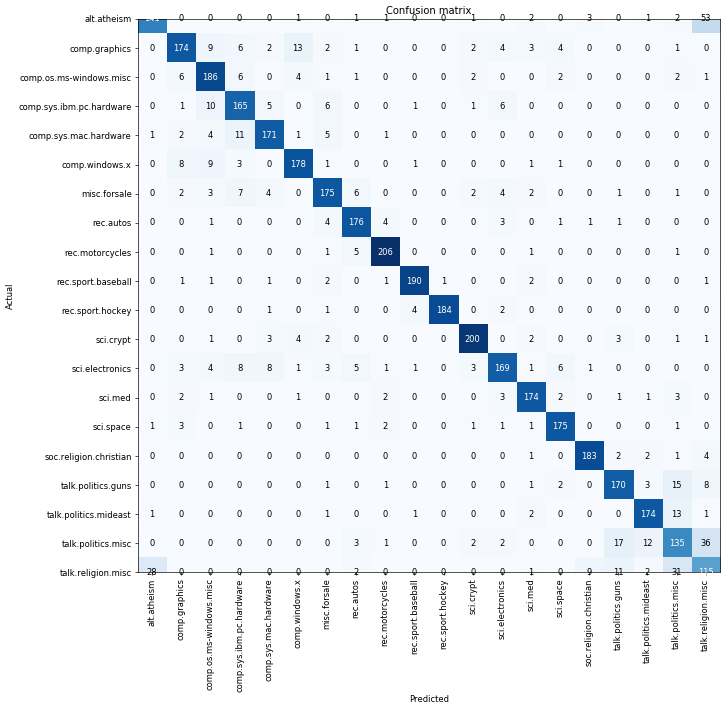

In [24]:
interp_I.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
print(['Actual','Predicted','Mislabeled'])
interp_I.most_confused(min_val=10)

['Actual', 'Predicted', 'Mislabeled']


[('alt.atheism', 'talk.religion.misc', 53),
 ('talk.politics.misc', 'talk.religion.misc', 36),
 ('talk.religion.misc', 'talk.politics.misc', 31),
 ('talk.religion.misc', 'alt.atheism', 28),
 ('talk.politics.misc', 'talk.politics.guns', 17),
 ('talk.politics.guns', 'talk.politics.misc', 15),
 ('comp.graphics', 'comp.windows.x', 13),
 ('talk.politics.mideast', 'talk.politics.misc', 13),
 ('talk.politics.misc', 'talk.politics.mideast', 12),
 ('comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 11),
 ('talk.religion.misc', 'talk.politics.guns', 11),
 ('comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 10)]

### Export the model

In [75]:
learn_clas.export(file = 'export_clas.pkl')

### Import the model

In [38]:
learn_exp = load_learner('.', 'export_clas.pkl')

In [62]:
def export_model_interpret_train(r):
    ori_path = predict_df.iloc[r].c_filename
    local_path = ori_path.replace("p1thiyya\\Downloads", "pradeep.thiyyagura\\Documents\\Learning\\Meetup_19")
    file_text = extract_contents(local_path)
    cat_i, num_cat_i,prob_i = learn_exp.predict(file_text)
    prob_per = [prob*100 for prob in prob_i.numpy()]
    print("Actual: {}, Precition: {}, Probaility: {}".format(predict_df.iloc[r].actual_label, cat_i, round(prob_per[num_cat_i],2)))
    #print("Record_Seires_Prediction_ID : {}".format(num_cat_i.numpy().tolist()))
    #interp_T.show_intrinsic_attention(file_text)

In [73]:
export_model_interpret_train(5)

C:\Users\pradeep.thiyyagura\AppData\Local\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Actual: comp.graphics, Precition: sci.crypt, Probaility: 100.0


### Make Predictions on external text

In [71]:
custom_text = "Samsung's first shot at a foldable phone is off to a bumpy start, but it appears the company has more plans for the concept in the pipeline.The company teased at its annual Samsung (SSNLF) Developer Conference on Tuesday a mobile device with a clamshell form factor. In a video showed on stage, the Galaxy Fold smartphone transforms from a flip phone that opens vertically to one that expands horizontally."
custom_text

"Samsung's first shot at a foldable phone is off to a bumpy start, but it appears the company has more plans for the concept in the pipeline.The company teased at its annual Samsung (SSNLF) Developer Conference on Tuesday a mobile device with a clamshell form factor. In a video showed on stage, the Galaxy Fold smartphone transforms from a flip phone that opens vertically to one that expands horizontally."

In [72]:
learn_exp.predict(custom_text)

C:\Users\pradeep.thiyyagura\AppData\Local\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category sci.electronics,
 tensor(12),
 tensor([8.4951e-07, 1.2918e-04, 3.2803e-03, 5.6702e-02, 1.2349e-03, 1.5297e-05,
         4.4244e-04, 1.9535e-03, 5.9851e-05, 3.5062e-06, 1.1902e-05, 5.0880e-04,
         9.3534e-01, 3.1079e-04, 2.2386e-06, 2.7401e-06, 6.8466e-07, 3.0125e-07,
         6.1629e-07, 1.2861e-06]))

In [67]:
custom_text = "Just when you were wondering whatever happened to Jared Kushner, the White House adviser who got his job because his father-in-law is President, he popped up on an Israeli TV station on Monday to jab at the Democrat who may be on the ballot opposing President Donald Trump in 2020. He said he's been busy cleaning up the messes that former Vice President Joe Biden was supposedly responsible for creating related to the Middle East and criminal justice."
custom_text

"Just when you were wondering whatever happened to Jared Kushner, the White House adviser who got his job because his father-in-law is President, he popped up on an Israeli TV station on Monday to jab at the Democrat who may be on the ballot opposing President Donald Trump in 2020. He said he's been busy cleaning up the messes that former Vice President Joe Biden was supposedly responsible for creating related to the Middle East and criminal justice."

In [68]:
learn_exp.predict(custom_text)

C:\Users\pradeep.thiyyagura\AppData\Local\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category talk.politics.mideast,
 tensor(17),
 tensor([2.1658e-07, 6.3029e-09, 5.1435e-09, 8.6563e-09, 5.4176e-08, 5.4007e-08,
         2.2440e-07, 2.0075e-06, 6.1153e-07, 4.6601e-07, 6.6987e-07, 1.3581e-06,
         5.2285e-09, 1.4311e-07, 1.4564e-06, 6.3407e-07, 3.9609e-04, 7.7187e-01,
         2.2770e-01, 2.5708e-05]))

In [64]:
export_model_interpret_train(5)

C:\Users\pradeep.thiyyagura\AppData\Local\Continuum\anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Actual: comp.graphics, Precition: sci.crypt, Probaility: 100.0


## Model Interpretation

In [61]:
interp_T = TextClassificationInterpretation.from_learner(learn_clas)

In [40]:
r = 580

In [43]:
def model_interpret(r):
    cat_i, num_cat_i,prob_i = learn_clas.predict(df_test.iloc[r].File_text)
    prob_per = [prob*100 for prob in prob_i.numpy()]
    print("Actual: {}, Precition: {}, Probaility: {}".format(df_test.iloc[r].File_label, cat_i, round(prob_per[num_cat_i],2)))
    #print("Record_Seires_Prediction_ID : {}".format(num_cat_i.numpy().tolist()))
    interp_T.show_intrinsic_attention(df_test.iloc[r].File_text)

In [45]:
model_interpret(580)

C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Actual: comp.os.ms-windows.misc, Precition: comp.os.ms-windows.misc, Probaility: 99.87


C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


In [46]:
model_interpret(1098)

C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Actual: comp.windows.x, Precition: comp.windows.x, Probaility: 99.99


C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


### Incorrect Prediction

But it makes sense the email address was given more importance. we should probably use regular expression and clean the data further

In [47]:
model_interpret(1)

C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Actual: alt.atheism, Precition: talk.religion.misc, Probaility: 56.23


C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


## Predictions and interpreatation from outside data

In [66]:
cnn_bussiness = "Virgin Galactic began trading on the New York Stock exchange Monday — another sign that entrepreneur-built space companies are maturing.The startup is trading under the ticker SPCE, replacing the IPOA moniker that Galactic's merger partner, Social Capital Hedosophia, has traded under since 2017."
cnn_bussiness

"Virgin Galactic began trading on the New York Stock exchange Monday — another sign that entrepreneur-built space companies are maturing.The startup is trading under the ticker SPCE, replacing the IPOA moniker that Galactic's merger partner, Social Capital Hedosophia, has traded under since 2017."

In [49]:
learn_clas.predict(cnn_bussiness)

C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category sci.space,
 tensor(14),
 tensor([1.4023e-03, 6.9076e-06, 5.5106e-04, 8.7064e-05, 9.3099e-03, 2.2461e-04,
         6.8057e-02, 1.1286e-03, 1.4833e-04, 5.6959e-03, 3.8950e-05, 4.1646e-02,
         1.8721e-03, 3.6487e-04, 7.6670e-01, 1.1644e-02, 1.8370e-03, 3.7896e-03,
         5.2911e-02, 3.2588e-02]))

In [50]:
interp_T.show_intrinsic_attention(cnn_bussiness)

C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


## Inspect High Loss

In [65]:
predict_df.reset_index(drop=True).head()

,c_filename,Loss,actual_label,actual_label_prob,predicted_label,predicted_label_prob,second_label,second_label_prob,third_label,third_label_prob
0,C:\Users\p1thiyya\Downloads\20_newsgroups\comp...,20.806932,comp.graphics,0.0,misc.forsale,100.000000,sci.electronics,0.0,comp.sys.ibm.pc.hardware,0.00
1,C:\Users\p1thiyya\Downloads\20_newsgroups\comp...,17.244532,comp.sys.ibm.pc.hardware,0.0,misc.forsale,100.000000,comp.os.ms-windows.misc,0.0,comp.graphics,0.00
2,C:\Users\p1thiyya\Downloads\20_newsgroups\misc...,16.606749,misc.forsale,0.0,comp.sys.ibm.pc.hardware,100.000000,rec.autos,0.0,comp.os.ms-windows.misc,0.00
3,C:\Users\p1thiyya\Downloads\20_newsgroups\sci....,16.249413,sci.electronics,0.0,comp.sys.ibm.pc.hardware,100.000000,misc.forsale,0.0,comp.os.ms-windows.misc,0.00
4,C:\Users\p1thiyya\Downloads\20_newsgroups\comp...,14.889646,comp.graphics,0.0,comp.sys.ibm.pc.hardware,99.199997,sci.electronics,0.4,comp.sys.mac.hardware,0.23


In [63]:
def model_interpret_train(r):
    file_text = extract_contents(predict_df.iloc[r].c_filename)
    cat_i, num_cat_i,prob_i = learn_clas.predict(file_text)
    prob_per = [prob*100 for prob in prob_i.numpy()]
    print("Actual: {}, Precition: {}, Probaility: {}".format(predict_df.iloc[r].actual_label, cat_i, round(prob_per[num_cat_i],2)))
    #print("Record_Seires_Prediction_ID : {}".format(num_cat_i.numpy().tolist()))
    interp_T.show_intrinsic_attention(file_text)

In [64]:
model_interpret_train(0)

C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Actual: comp.graphics, Precition: misc.forsale, Probaility: 100.0


C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


In [66]:
model_interpret_train(1)

C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Actual: comp.sys.ibm.pc.hardware, Precition: misc.forsale, Probaility: 100.0


C:\Users\p1thiyya\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


## Model was correct in both the above cases!!!